In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
from scipy.special import expit
from functools import partial



import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [330]:
def my_beeswarm(df: pd.DataFrame, features: list[str],
                cat_feature_threshold: float, shap_values: np.ndarray,
                top_k: int = 10, figsize: tuple[int, int] = (10, 6),
                dots: int = 1000) -> plt.Figure:
    """
    Улучшенная версия beeswarm plot для визуализации SHAP значений.

    Параметры:
    ----------
    df : pd.DataFrame
        Исходные данные
    features : list[str]
        Список признаков
    cat_feature_threshold : float
        Порог для отображения категориальных значений (минимальная частота)
    shap_values : np.ndarray
        SHAP значения (N x F+1), последний столбец - константа
    top_k : int, optional
        Количество топовых признаков для отображения (по умолчанию 10)
    figsize : tuple[int, int], optional
        Размер фигуры (по умолчанию (10, 6))
    dots : int, optional
        Количество точек для отображения (по умолчанию 1000)

    Возвращает:
    -----------
    plt.Figure
        Объект matplotlib Figure с визуализацией
    """

    # 1. Предобработка SHAP значений
    shap_values = shap_values[:, :-1]
    df_shap = pd.DataFrame(shap_values, columns=features)

    # 2. Обработка категориальных признаков
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    for cat in cat_cols:
        if cat not in features:
            continue

        value_counts = df[cat].value_counts(normalize=True)
        filtered_values = value_counts[value_counts >= cat_feature_threshold].index

        new_cols = {
            f"{cat} == {value}": (df[cat] == value).astype(int)
            for value in filtered_values
        }

        # Создаем новер бинарные признаки
        new_df = pd.DataFrame(new_cols)
        df = pd.concat([df, new_df], axis=1)

        # Для SHAP значений - копируем оригинальные значения только для соответствующих категорий
        for value in filtered_values:
            mask = (df[cat] == value)
            df_shap[f"{cat} == {value}"] = np.where(mask, df_shap[cat], 0)

        df.drop(columns=[cat], inplace=True)
        df_shap.drop(columns=[cat], inplace=True)

    # 3. Выбор top_k признаков
    mean_shap_value = df_shap.abs().mean().sort_values(ascending=False)
    top_features = mean_shap_value.head(top_k).index.tolist()

    # 4. Сэмплирование
    if len(df) > dots:
        index_sample = np.random.choice(df.index, size=dots, replace=False)
        df_sampled = df.loc[index_sample]
        df_shap_sampled = df_shap.loc[index_sample]
    else:
        df_sampled = df.copy()
        df_shap_sampled = df_shap.copy()

    fig, ax = plt.subplots(figsize=figsize)

    # 5. Построение графика для каждого признака
    for i, feature in enumerate(top_features):
        # Подготовка данных для текущего признака
        shap_data = df_shap_sampled[feature]
        feature_data = df_sampled[feature] if feature in df_sampled else None

        # Разделение на пропущенные и непропущенные значения
        if feature_data is not None:
            is_missing = feature_data.isna()
            missing_shap = shap_data[is_missing]
            non_missing_shap = shap_data[~is_missing]
            non_missing_values = feature_data[~is_missing]
        else:
            # Для dummy-переменных нет пропущенных значений
            is_missing = pd.Series(False, index=shap_data.index)
            non_missing_shap = shap_data
            non_missing_values = None

        # Визуализация непропущенных значений
        if len(non_missing_shap) > 0:
            if " == " in feature:  # Категориальный признак
                sns.stripplot(
                    x=non_missing_shap.values,
                    y=[feature] * len(non_missing_shap),
                    ax=ax,
                    color='purple',
                    alpha=0.7,
                    jitter=0.3,
                    size=4,
                    linewidth=0.5
                )
            else:  # Числовой признак
                # Подготовка данных для цветового градиента
                vals = non_missing_values
                if vals.nunique() > 1:
                    # Обрезка выбросов для цветовой шкалы
                    vmin, vmax = vals.quantile([0.01, 0.99])
                    clipped_vals = vals.clip(vmin, vmax)

                    # Создаем DataFrame для stripplot, но можно было и просто записать все в параметры напрямую
                    plot_df = pd.DataFrame({
                        'shap': non_missing_shap.values,
                        'feature': [feature] * len(non_missing_shap),
                        'value': clipped_vals
                    })

                    # Рисуем с цветовым градиентом
                    sns.stripplot(
                        x='shap',
                        y='feature',
                        hue='value',
                        data=plot_df,
                        ax=ax,
                        palette='coolwarm',
                        alpha=0.7,
                        jitter=0.3,
                        size=4,
                        linewidth=0.5,
                        hue_norm=(vmin, vmax)
                    )

                    # Убираем легенду, потому что она будет дублировать colorbar
                    ax.get_legend().remove()
                else:
                    # Если все значения одинаковые - синий цвет
                    sns.stripplot(
                        x=non_missing_shap.values,
                        y=[feature] * len(non_missing_shap),
                        ax=ax,
                        color='blue',
                        alpha=0.7,
                        jitter=0.3,
                        size=4,
                        linewidth=0.5
                    )

        # Визуализация пропущенных значений
        if len(missing_shap) > 0:
            ax.plot(
                missing_shap.values,
                [feature]*len(missing_shap),
                'o',
                color='black',
                alpha=0.9,
                markersize=4,
                markeredgecolor='black',
                markeredgewidth=1,
                zorder = 10
            )

    # Добавление вертикальной линии на 0
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

    ax.set_xlabel('SHAP value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.set_title('Custom Beeswarm Plot of SHAP Values', fontsize=14)

    # Добавление colorbar для числовых признаков
    if any(" == " not in f for f in top_features):
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Feature value (normalized)', rotation=270, labelpad=15)

    plt.tight_layout()

In [331]:
def plot_ensemble_profile(t):
    t['abs_value'] = t.value.abs()
    mosaic = [
        ['weights', 'abs_weights', 'depth'],
        ['cnt', 'hess', 'gain']
    ]
    fig, ax = plt.subplot_mosaic(mosaic, figsize=(15, 8))

    ax['weights'].set_title('Веса в листьях', fontsize=12)
    sns.scatterplot(t.query('split_gain.isnull()'), x='tree_index', y='value', s=50, ax=ax['weights'])
    sns.lineplot(t.query('split_gain.isnull()'), x='tree_index', y='value',  color='orange', lw=3, ax=ax['weights'])

    ax['abs_weights'].set_title('Модули весов в листьях', fontsize=12)
    sns.scatterplot(t.query('split_gain.isnull()'), x='tree_index', y='abs_value', s=50, ax=ax['abs_weights'])
    sns.lineplot(t.query('split_gain.isnull()'), x='tree_index', y='abs_value',  color='orange', lw=3, ax=ax['abs_weights'])

    ax['cnt'].set_title('Количество объектов в листьях', fontsize=12)
    sns.scatterplot(t.query('split_gain.isnull()'), x='tree_index', y='count', s=50, ax=ax['cnt'])
    sns.lineplot(t.query('split_gain.isnull()'), x='tree_index', y='count',  color='orange', lw=3, ax=ax['cnt'])
    ax['cnt'].set_yscale('log')

    ax['hess'].set_title('sum_hessian в знаменателе при сплитах', fontsize=12)
    sns.scatterplot(t, x='tree_index', y='weight', s=50, ax=ax['hess'])
    sns.lineplot(t, x='tree_index', y='weight',  color='orange', lw=3, ax=ax['hess'])
    ax['hess'].set_yscale('log')

    ax['depth'].set_title('Глубина деревьев', fontsize=12)
    sns.scatterplot(t, x='tree_index', y='node_depth', s=50, ax=ax['depth'])
    sns.lineplot(t, x='tree_index', y='node_depth',  color='orange', lw=3, ax=ax['depth'])

    ax['gain'].set_title('Gain', fontsize=12)
    sns.scatterplot(t, x='tree_index', y='split_gain', s=50, ax=ax['gain'])
    sns.lineplot(t, x='tree_index', y='split_gain',  color='orange', lw=3, ax=ax['gain'])
    ax['gain'].set_yscale('log')

    fig.tight_layout()

In [332]:
def plot_feature_depth(t, top_k=20):
    t_prep = t.copy()
    t_prep.split_feature = t_prep.split_feature.astype('category')
    t_prep = (
        t_prep.query('~split_feature.isnull()')
        .groupby(['node_depth', 'split_feature'], observed=True)
        .size()
        .to_frame('cnt')
        .reset_index()
    )
    t_prep.cnt = t_prep.cnt / 2**(t_prep.node_depth - 1)
    t_prep = t_prep.pivot_table(values='cnt', columns='node_depth', index='split_feature')
    median_cnt = t_prep.sum(axis=1)
    idx = np.argsort(median_cnt)[::-1][:top_k]
    
    sns.heatmap(t_prep.iloc[idx], cmap='coolwarm', annot=False, robust=True)
    plt.gcf().set_size_inches(6, top_k/6 + 1)

In [348]:
def custom_epsilon_loss_grad_hess(y_raw, tr_data=None, y_true=None, alpha=1.2, beta=0.9, epsilon=1, p=2):
    """
    Улучшенная версия epsilon-insensitive asymmetric loss с диагностикой.
    """
    # Получаем истинные значения
    if y_true is None:
        y_true = tr_data.get_label()
    
    # Проверка размерностей
    assert len(y_raw) == len(y_true), f"Размеры не совпадают: y_raw {len(y_raw)}, y_true {len(y_true)}"
    
    residuals = y_raw - y_true
    
    # Диагностика: выводим статистику по остаткам
    print("\nДиагностика лосса:")
    print(f"Сырые предсказания: min={np.min(y_raw):.2f}, max={np.max(y_raw):.2f}")
    print(f"Истинные значения: min={np.min(y_true):.2f}, max={np.max(y_true):.2f}")
    print(f"Остатки: min={np.min(residuals):.2f}, max={np.max(residuals):.2f}")
    
    # Инициализация градиента и гессиана
    grad = np.zeros_like(residuals)
    hess = np.zeros_like(residuals)
    
    # Маски для разных случаев
    within_epsilon = np.abs(residuals) <= epsilon
    overestimation = residuals > epsilon
    underestimation = residuals < -epsilon
    
    print(f"Точек в epsilon: {np.sum(within_epsilon)}")
    print(f"Переоценок: {np.sum(overestimation)}")
    print(f"Недооценок: {np.sum(underestimation)}")
    
    # Вычисление градиента
    grad[overestimation] = alpha * p * (residuals[overestimation] - epsilon)**(p-1)
    grad[underestimation] = -beta * p * (-residuals[underestimation] - epsilon)**(p-1)
    
    # Вычисление гессиана
    if p > 1:
        hess[overestimation] = alpha * p * (p-1) * (residuals[overestimation] - epsilon)**(p-2)
        hess[underestimation] = beta * p * (p-1) * (-residuals[underestimation] - epsilon)**(p-2)
    
    # Защита от численной нестабильности
    grad = np.nan_to_num(grad, nan=0.0, posinf=0.0, neginf=0.0)
    hess = np.nan_to_num(hess, nan=0.0, posinf=0.0, neginf=0.0)
    
    print(f"Градиент: min={np.min(grad):.2f}, max={np.max(grad):.2f}")
    print(f"Гессиан: min={np.min(hess):.2f}, max={np.max(hess):.2f}")
    
    return grad, hess

In [334]:
def create_numeric_interactions(df, numeric_features):
    """
    Создает новые признаки на основе взаимодействий числовых признаков
    """    

    # Генерируем все возможные пары
    for i, feat1 in enumerate(numeric_features):
        for feat2 in numeric_features[i+1:]:
            df[f'{feat1}_plus_{feat2}'] = df[feat1] + df[feat2]
            df[f'{feat1}_minus_{feat2}'] = df[feat1] - df[feat2]
            df[f'{feat1}_mul_{feat2}'] = df[feat1] * df[feat2]
            df[f'{feat1}_div_{feat2}'] = df[feat1] / (df[feat2] + 1e-6)
            df[f'{feat1}_dist_{feat2}'] = (df[feat1]**2 - df[feat2]**2)**(1/2)
    
    return df

In [335]:
def create_categorical_combinations(df, cat_features, top_n=10):
    """
    Создает попарные комбинации категориальных признаков
    Выбирает только top_n самых популярных комбинаций для каждого признака
    """
    
    for i, feat1 in enumerate(cat_features):
        for feat2 in cat_features[i+1:]:
            # Создаем комбинацию
            comb_name = f'{feat1}_and_{feat2}'
            new_feat = df[feat1].astype(str) + '_' + df[feat2].astype(str)
            
            # Оставляем только top_n самых частых значений, остальные заменяем на 'other'
            top_values = new_feat.value_counts().head(top_n).index
            new_feat[~new_feat.isin(top_values)] = 'other'
            
            df[comb_name] = new_feat.astype('category')
    
    return df

In [336]:
def EDA(tr, tst, num_cols, cat_cols):
    tr = create_numeric_interactions(tr, num_cols)
    print("tr num")
    tst = create_numeric_interactions(tst, num_cols)
    print("tst num")

    #tr = create_categorical_combinations(tr, cat_cols)
    #print("tr cat")
    #tst = create_categorical_combinations(tst, cat_cols)
    #print("tst cat")

    return tr, tst

In [350]:
from sklearn.model_selection import train_test_split

train = pd.read_csv('train_contest.csv')
test = pd.read_csv('test_contest.csv')

target = train['target']
#target_log = np.log1p(target)

train = train.drop('target', axis=1)

start_cat_features = train.select_dtypes(include=['category', 'object']).columns.tolist()
start_num_features = train.select_dtypes(include=['int', 'float']).columns.tolist()

for feat in start_cat_features:
    train[feat] = train[feat].astype('category')

train, test = EDA(train, test, start_num_features, start_cat_features)

features = list(train.columns)

X_train, X_val, y_train, y_val = train_test_split(
    train[features], 
    target, 
    test_size=0.3, 
    random_state=911
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_604\2337427768.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Admin\AppData\Local\Temp\ipykernel_604\2337427768.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Admin\AppData\Local\Temp\ipykernel_604\2337427768.py:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

tr num


C:\Users\Admin\AppData\Local\Temp\ipykernel_604\2337427768.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Admin\AppData\Local\Temp\ipykernel_604\2337427768.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Admin\AppData\Local\Temp\ipykernel_604\2337427768.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

tst num


In [355]:
cat_features = train.select_dtypes(include=['category', 'object']).columns.tolist()
num_features = train.select_dtypes(include=['int', 'float']).columns.tolist()

lgb_tr = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
lgb_val = lgb.Dataset(X_val, y_val, categorical_feature=cat_features, reference=lgb_tr)

gamma = 0

params = {
    'objective': partial(custom_epsilon_loss_grad_hess,
                       alpha=1.0,     # штраф за переоценку
                       beta=4.0,      # УВЕЛИЧЕННЫЙ штраф за недооценку
                       epsilon=5000,  # УВЕЛИЧЕННАЯ зона нечувствительности
                       p=1.8          # Более близко к L2
    ),
    'metric': 'mae',
    'learning_rate': 0.03,  # Уменьшенный шаг обучения
    'max_depth': 4,         # Меньшая глубина
    'num_leaves': 15,
    'lambda_l1': 15,        # Усиленная регуляризация
    'lambda_l2': 15,
    'feature_fraction': 0.8, # Случайный выбор признаков
    'min_data_in_leaf': 50   # Минимум точек в листе
}

model = lgb.train(
    train_set= lgb_tr,
    valid_sets= [lgb_tr, lgb_val],
    valid_names= ['tr', 'val'],
    num_boost_round= 1000,
    callbacks= [
        lgb.log_evaluation(period=20),
        lgb.early_stopping(50)
    ],
    params=params
)


Диагностика лосса:
Сырые предсказания: min=0.00, max=0.00
Истинные значения: min=0.67, max=121012.25
Остатки: min=-121012.25, max=-0.67
Точек в epsilon: 70116
Переоценок: 0
Недооценок: 13949
Градиент: min=-81084.08, max=0.00
Гессиан: min=0.00, max=7.33
Training until validation scores don't improve for 50 rounds

Диагностика лосса:
Сырые предсказания: min=36.62, max=360.20
Истинные значения: min=0.67, max=121012.25
Остатки: min=-120777.34, max=71.70
Точек в epsilon: 70487
Переоценок: 0
Недооценок: 13578
Градиент: min=-80952.70, max=0.00
Гессиан: min=0.00, max=6.99

Диагностика лосса:
Сырые предсказания: min=73.77, max=710.59
Истинные значения: min=0.67, max=121012.25
Остатки: min=-120545.98, max=142.61
Точек в epsilon: 70802
Переоценок: 0
Недооценок: 13263
Градиент: min=-80823.26, max=0.00
Гессиан: min=0.00, max=9.29

Диагностика лосса:
Сырые предсказания: min=100.02, max=1053.00
Истинные значения: min=0.67, max=121012.25
Остатки: min=-120320.79, max=337.10
Точек в epsilon: 71128
Пере

[157]	tr's l1: 1074.77	val's l1: 1185.7
    alpha=1.2,
    beta=0.9,
    epsilon=1,
    p=2



    

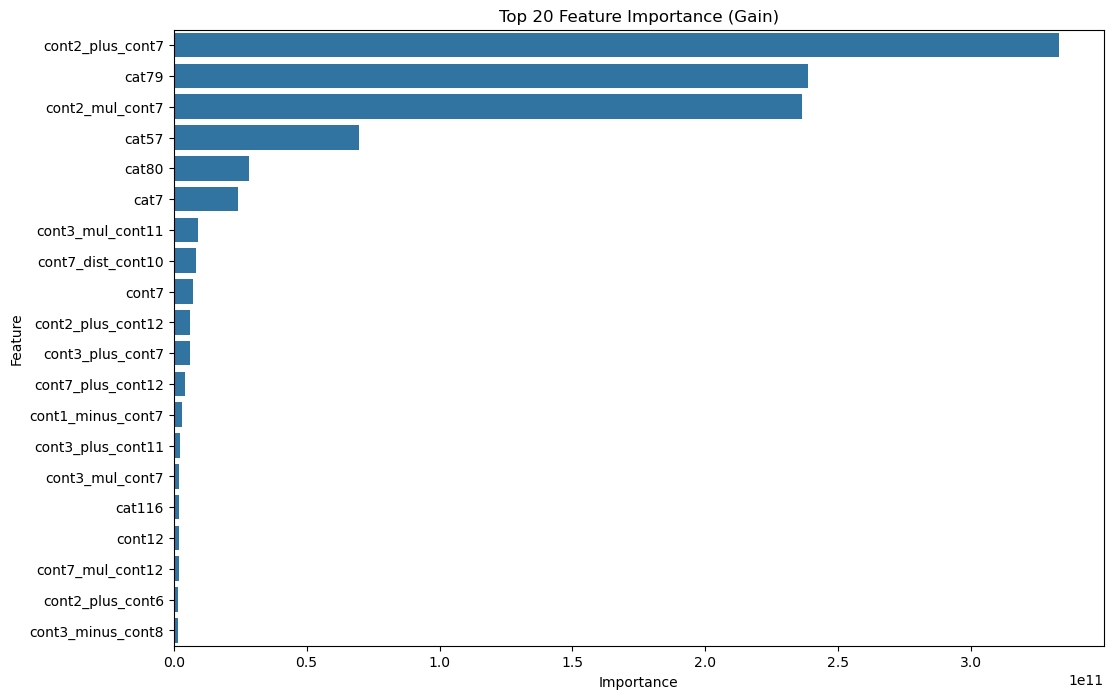

In [356]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем важность признаков
importance = model.feature_importance(importance_type='gain')  # 'split' или 'gain'
feature_names = model.feature_name()

# Создаем DataFrame для удобства
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Визуализация топ-20 признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importance (Gain)')
plt.show()

# Можно также сохранить в файл
importance_df.to_csv('feature_importance.csv', index=False)

In [340]:
X_train

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont12_plus_cont14,cont12_minus_cont14,cont12_mul_cont14,cont12_div_cont14,cont12_dist_cont14,cont13_plus_cont14,cont13_minus_cont14,cont13_mul_cont14,cont13_div_cont14,cont13_dist_cont14
66120,A,A,A,A,B,B,A,A,A,A,...,1.448546,-0.201118,0.514459,0.756170,NaN,1.744659,0.094995,0.758703,1.115168,0.407104
817,A,A,A,B,A,B,A,A,A,A,...,0.415710,0.034866,0.042900,1.183092,0.120392,0.553969,0.173125,0.069227,1.909155,0.309687
31396,A,A,A,A,A,B,A,A,A,A,...,0.914062,0.124850,0.204980,1.316388,0.337817,0.999683,0.210471,0.238767,1.533366,0.458698
109955,B,A,A,A,B,A,A,A,A,A,...,0.944570,0.237352,0.208969,1.671223,0.473493,1.149369,0.442151,0.281388,2.250389,0.712878
115264,A,B,A,A,A,B,A,A,B,A,...,1.711364,0.047330,0.731632,1.056885,0.284603,1.602905,-0.061129,0.641392,0.926528,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86299,A,B,A,A,A,B,A,A,B,B,...,1.207219,-0.446029,0.314609,0.460420,NaN,1.490363,-0.162885,0.548663,0.802951,NaN
19004,A,B,A,A,A,A,A,A,B,B,...,1.516991,-0.081695,0.573647,0.897796,NaN,1.553332,-0.045354,0.602696,0.943260,NaN
34760,A,A,A,A,B,A,A,B,A,A,...,0.474598,0.008754,0.056292,1.037579,0.064456,0.531656,0.065812,0.069582,1.282544,0.187054
73394,A,B,B,A,A,A,A,A,B,B,...,1.149366,0.556364,0.252875,2.876422,0.799666,0.951254,0.358252,0.194135,2.208258,0.583771


In [357]:
for feat in cat_features:
    test[feat] = test[feat].astype('category')

#test['target'] = np.expm1(model.predict(test[features]))
test['target'] = model.predict(test[features])


test[['index', 'target']].to_csv('EDA+val.csv', index=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_604\3057800210.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [342]:
#shap_values = model.predict(test[features], pred_contrib=True)
#my_beeswarm(test, features, cat_feature_threshold=0.001, shap_values=shap_values, top_k=13, figsize=(10, 6), dots=1000)

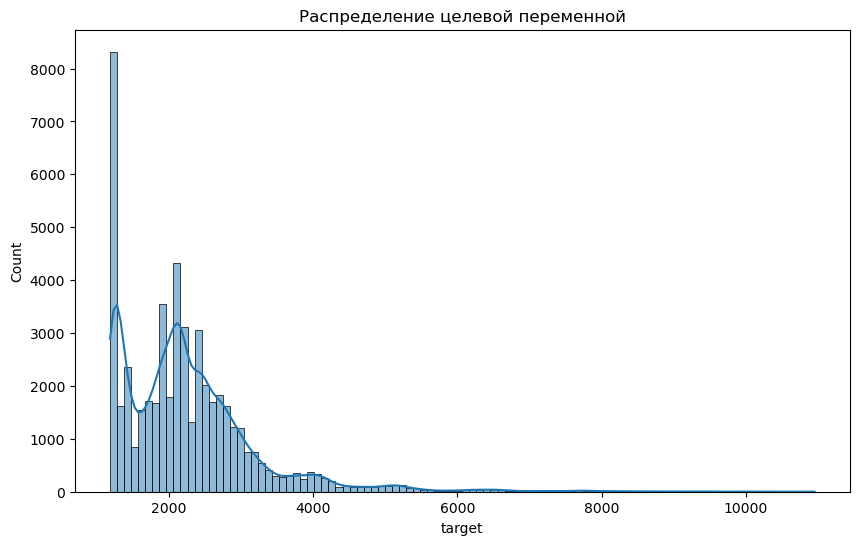

In [358]:
# Анализ распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(data=test, x='target', bins=100, kde=True)
plt.title('Распределение целевой переменной')
plt.show()

In [344]:
#t = model.trees_to_dataframe()
#plot_feature_depth(t, 40)
#plot_ensemble_profile(t)

In [345]:
#t1 = t.query('node_depth == 1')
#t1[t1['split_feature'] == 'cat116']

In [347]:
train

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont12_plus_cont14,cont12_minus_cont14,cont12_mul_cont14,cont12_div_cont14,cont12_dist_cont14,cont13_plus_cont14,cont13_minus_cont14,cont13_mul_cont14,cont13_div_cont14,cont13_dist_cont14
0,B,A,A,B,A,B,A,A,A,A,...,1.370848,0.013664,0.469759,1.020134,0.136862,1.195252,-0.161932,0.350601,0.761369,NaN
1,A,B,A,A,A,A,A,B,B,A,...,0.867521,0.394185,0.149303,2.665550,0.584777,0.591012,0.117676,0.083862,1.497213,0.263719
2,B,B,A,A,A,B,A,A,B,A,...,1.593840,0.164854,0.628287,1.230727,0.512592,1.535031,0.106045,0.586269,1.148418,0.403463
3,A,A,A,B,A,A,A,A,A,A,...,0.991685,0.270021,0.227632,1.748324,0.517471,0.567248,-0.154416,0.074481,0.572054,NaN
4,A,B,A,A,A,A,A,A,B,B,...,0.689111,0.123069,0.114932,1.434835,0.291218,0.655873,0.089831,0.105525,1.317396,0.242730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120089,A,B,A,A,A,A,A,A,B,B,...,0.762049,0.200563,0.135123,1.714395,0.390946,1.053978,0.492492,0.217080,2.754235,0.720469
120090,A,B,A,A,A,A,A,A,B,B,...,0.825891,0.060857,0.169598,1.159093,0.224190,0.692543,-0.072491,0.118590,0.810487,NaN
120091,A,B,A,B,B,A,B,B,B,B,...,1.639599,0.025717,0.671906,1.031868,0.205343,1.617452,0.003570,0.654035,1.004423,0.075989
120092,B,B,A,A,A,A,A,A,B,A,...,0.715234,-0.231882,0.114448,0.510340,NaN,0.734708,-0.212408,0.123670,0.551462,NaN


In [346]:
ы

NameError: name 'ы' is not defined

In [ ]:
cat_features = train.select_dtypes(include=['category', 'object']).columns.tolist()
num_features = train.select_dtypes(include=['int', 'float']).columns.tolist()

lgb_df = lgb.Dataset(data=train[features], label=target, categorical_feature=cat_features)

full_model = lgb.train(
    train_set= lgb_df,
    valid_sets= [lgb_df],
    num_boost_round= 200,
    callbacks= [
        lgb.log_evaluation(period=20),
        lgb.early_stopping(50)
    ],
    params=params
)


Диагностика лосса:
Сырые предсказания: min=0.00, max=0.00
Истинные значения: min=0.67, max=121012.25
Остатки: min=-121012.25, max=-0.67
Точек в epsilon: 1
Переоценок: 0
Недооценок: 120093
Градиент: min=-217820.25, max=0.00
Гессиан: min=0.00, max=1.80


c:\Users\Admin\anaconda3\Lib\site-packages\lightgbm\callback.py:347: UserWarning:

Only training set found, disabling early stopping.




Диагностика лосса:
Сырые предсказания: min=144.90, max=2885.07
Истинные значения: min=0.67, max=121012.25
Остатки: min=-118127.18, max=961.08
Точек в epsilon: 5
Переоценок: 268
Недооценок: 119821
Градиент: min=-212627.13, max=2304.18
Гессиан: min=0.00, max=2.40

Диагностика лосса:
Сырые предсказания: min=263.63, max=5489.22
Истинные значения: min=0.67, max=121012.25
Остатки: min=-117021.50, max=2027.97
Точек в epsilon: 18
Переоценок: 1319
Недооценок: 118757
Градиент: min=-210636.89, max=4864.73
Гессиан: min=0.00, max=2.40

Диагностика лосса:
Сырые предсказания: min=381.76, max=7904.56
Истинные значения: min=0.67, max=121012.25
Остатки: min=-114606.16, max=3881.35
Точек в epsilon: 40
Переоценок: 3963
Недооценок: 116091
Градиент: min=-206289.28, max=9312.85
Гессиан: min=0.00, max=2.40

Диагностика лосса:
Сырые предсказания: min=478.78, max=10198.45
Истинные значения: min=0.67, max=121012.25
Остатки: min=-113382.69, max=5516.71
Точек в epsilon: 63
Переоценок: 8221
Недооценок: 111810
Град

In [ ]:
for feat in cat_features:
    test[feat] = test[feat].astype('category')  # На всякий случай преобразуем
    test[feat] = test[feat].cat.set_categories(train[feat].cat.categories)

In [ ]:
test['target'] = full_model.predict(test[features])

test[['index', 'target']].to_csv('no log + 7225cols + fulldf.csv', index=False)

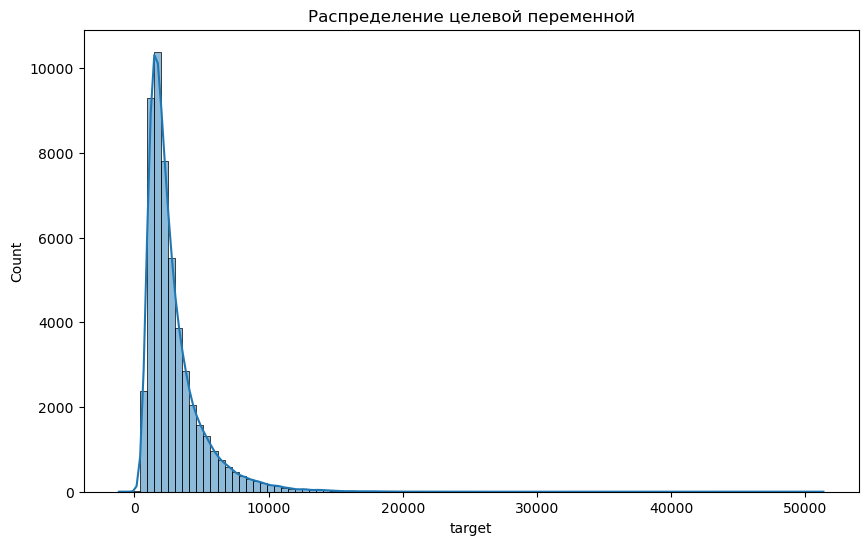

In [ ]:
# Анализ распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(data=test, x='target', bins=100, kde=True)
plt.title('Распределение целевой переменной')
plt.show()